In [41]:
from beattrack.model import BeatTCN
import torchaudio
from torchaudio.transforms import MelSpectrogram
from pathlib import Path
from IPython.display import Audio
import librosa
from einops import rearrange
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from madmom.features import DBNBeatTrackingProcessor
import librosa.display

In [42]:
n_fft = 2048
win_length = None
sample_rate = 44100
hop_size = round(sample_rate / 100)  # 10ms hop size
n_mels = 81
window = torch.hann_window(n_fft)
data_length = 30 * sample_rate  # 30 seconds of audio
mel_spec = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=win_length,
    n_mels=n_mels,
)
def preprocess(audio_path):
    audio, sr = torchaudio.load(audio_path)
    resample = torchaudio.transforms.Resample(
            orig_freq=sr, new_freq=sample_rate
    )
    audio = resample(audio)
    data_length = 30 * sample_rate  # 30 seconds of audio
    
    # Pad or trim to 30 seconds
    if audio.shape[1] < data_length:
        audio = F.pad(audio, (0, data_length - audio.shape[1]))
    else:
        audio = audio[:, :data_length]
    mel = mel_spec(audio)
    channels, bins, frames = mel.shape
    print(mel.shape)
    mel = rearrange(mel, "c b f -> f (b c)")
    print(mel.shape)
    return mel


In [72]:
model = BeatTCN.load_from_checkpoint("checkpoints/best1.ckpt")
model = model.eval()

dbn = DBNBeatTrackingProcessor(min_bpm=55, max_bpm=215, transition_labmda = 100, fps=100)
downbeat3_4 = DBNDownBeatTrackingProcessor(beats_per_bar=[3, 4], fps=100)
downbeat4_4 = DBNDownBeatTrackingProcessor(beats_per_bar=[4, 4], fps=100)

/Users/matthewrice/Developer/QMUL/Music_Informatics/beattrack/env/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.4, which is newer than your current Lightning version: v1.9.3
  rank_zero_warn(


In [51]:
files = []
root = Path("data/")
audio_root = root / "BallroomData"
for folder in audio_root.iterdir():
    if folder.is_dir():
        for file in folder.iterdir():
            if file.suffix == ".wav":
                files.append(file)

In [45]:
print(files)

[PosixPath('data/BallroomData/Waltz/Media-105901.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-04.wav'), PosixPath('data/BallroomData/Waltz/Media-104202.wav'), PosixPath('data/BallroomData/Waltz/Media-104203.wav'), PosixPath('data/BallroomData/Waltz/Media-105902.wav'), PosixPath('data/BallroomData/Waltz/Media-104201.wav'), PosixPath('data/BallroomData/Waltz/Media-104604.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-02.wav'), PosixPath('data/BallroomData/Waltz/Media-104402.wav'), PosixPath('data/BallroomData/Waltz/Media-104204.wav'), PosixPath('data/BallroomData/Waltz/Media-104205.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-03.wav'), PosixPath('data/BallroomData/Waltz/Media-104403.wav'), PosixPath('data/BallroomData/Waltz/Media-104601.wav'), PosixPath('data/BallroomData/Waltz/Media-104603.wav'), PosixPath('data/BallroomData/Waltz/Media-104401.wav'), PosixPath('data/BallroomData/Waltz/Albums-Step_By_Step-01.wav'), PosixPath('data/Ballroom

In [90]:
test = files[2]
mel = preprocess(test)

torch.Size([1, 81, 3001])
torch.Size([3001, 81])


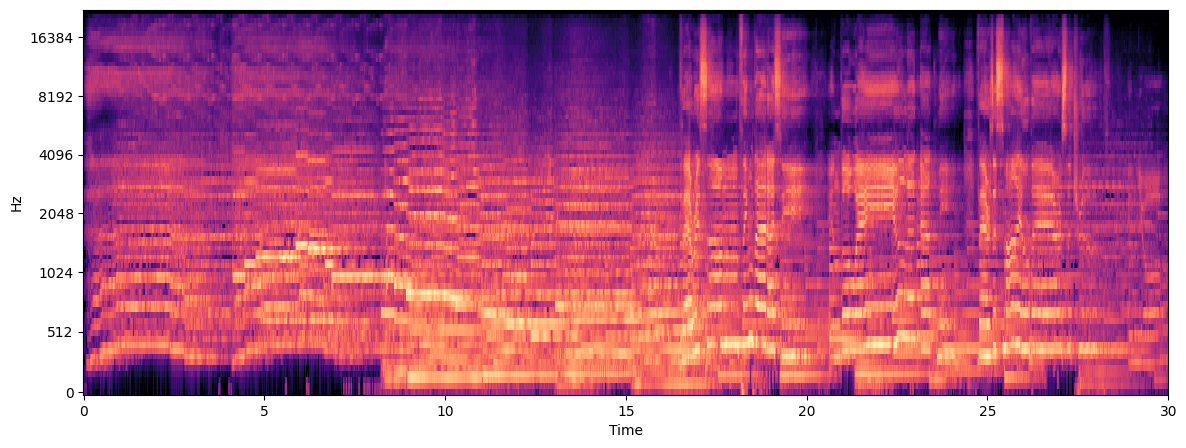

In [91]:
audio, sr = librosa.load(test, sr=sample_rate)
plt.figure(figsize=(14, 5))
S_dB = librosa.power_to_db(mel.T.numpy(), ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = n_fft, hop_length=hop_size)
Audio(audio, rate=sr)


In [92]:
mel = mel.unsqueeze(0).unsqueeze(0)
mel.shape

torch.Size([1, 1, 3001, 81])

In [93]:
with torch.no_grad():
    beats = model(mel)
beat_times = dbn(beats.view(-1))
# for beat in beats.view(-1):
#     print(beat)

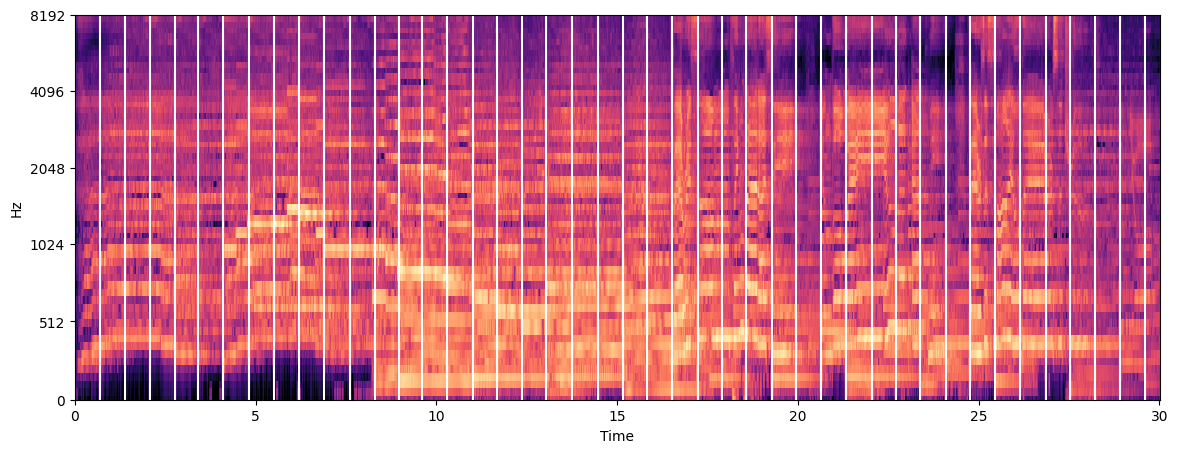

In [97]:
play_clicks = True
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel", n_fft = n_fft, hop_length=hop_size)
plt.vlines(beat_times, 0, 8192, color='w')
plt.ylim(0, 8192)

clicks = librosa.clicks(times = beat_times, sr=sr, length=len(audio))
output = audio
if play_clicks:
    output = audio + clicks
Audio(output, rate=sr)

In [66]:
def label2vec(label_file: Path, hop_size: int, num_frames: int) -> torch.Tensor:
    beats = [0] * num_frames
    downbeats = [0] * num_frames
    for line in label_file.open("r"):
        time, downbeat_num = line.split(" ")
        time_frame_id = round(float(time) * sample_rate / hop_size)
        if time_frame_id < num_frames:
            beats[time_frame_id] = 1
            if downbeat_num.strip() == "1":
                downbeats[time_frame_id] = 1

    return torch.tensor(beats), torch.tensor(downbeats)
label_root = root / "BallroomAnnotations"
label_file = label_root / f"{test.stem}.beats"
beats, downbeats = label2vec(label_file, hop_size, mel.shape[2])


In [67]:
beat_outputs = []
downbeat_outputs = []
for i, (beat, downbeat) in enumerate(zip(beats, downbeats)):
    if beat == 1:
        beat_outputs.append(i * hop_size / sample_rate)
    if downbeat == 1:
        downbeat_outputs.append(i * hop_size / sample_rate)